In [120]:
import sys
sys.path.append('../..')

import attack
import data_loader as dl

In [220]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt
from shapely import Point
import math
from tqdm import tqdm
tqdm.pandas()

In [221]:
# Load data
gdf = gp.read_file('full_trip_HL_clustering.geojson').to_crs(4326)

In [222]:
# format clusering_HL columns as object
gdf['clustering_HL'] = gdf['clustering_HL'].astype('object')

In [223]:
gdf['START_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[0]))
gdf['END_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[-1]))

In [ ]:
# plot trajectories of a random user and the corresponding clusters
user = random.choice(gdf['PERSON_ID'].unique())

# select random user
user_gdf = gdf[gdf['PERSON_ID'] == user]

# print nr of trajectories of user
print('Nr of trajectories of user: ', len(user_gdf))

# print nr of clusters of user
print('Nr of clusters of user: ', len(user_gdf['clustering_HL'].unique()))

# plot trajectories of user
user_gdf.explore(column='clustering_HL')


In [ ]:
# plot start and end points of user
gp.GeoDataFrame(user_gdf[['START_POINT', 'END_POINT', 'clustering_HL']], geometry='START_POINT').explore(column='clustering_HL')

In [324]:
def get_points(gdf, tessellation):
    sp = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_START', 'START_POINT', 'clustering_HL']].copy()
    ep = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_END', 'END_POINT', 'clustering_HL']].copy()


    sp['lat'] = sp.START_POINT.apply(lambda x: x.y)
    sp['lng'] = sp.START_POINT.apply(lambda x: x.x)
    ep['lat'] = ep.END_POINT.apply(lambda x: x.y)
    ep['lng'] = ep.END_POINT.apply(lambda x: x.x)

    sp = sp.rename(columns={'TRIP_START': 'datetime'})
    ep = ep.rename(columns={'TRIP_END': 'datetime'})

    sp.drop('START_POINT', axis=1, inplace=True)
    ep.drop('END_POINT', axis=1, inplace=True)

    points = pd.concat([sp, ep])
    points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.lng, points.lat, crs='epsg:4326'))
    
    points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
    
    return points

In [326]:
points = get_points(gdf, tessellation)

In [327]:
points

,PERSON_ID,TRIP_ID,datetime,clustering_HL,lat,lng,geometry,tile_ID
0,17246,0,2022-10-21T14:59:24,21,52.530942,13.317532,POINT (13.31753 52.53094),4868
1,17246,1,2022-10-21T16:07:38,21,52.538612,13.375194,POINT (13.37519 52.53861),5213
2,17246,2,2022-10-21T19:16:16,21,52.538529,13.375381,POINT (13.37538 52.53853),5213
3,17246,3,2022-10-21T20:41:59,73,52.531368,13.319161,POINT (13.31916 52.53137),4868
4,16947,4,2022-10-23T09:32:44,45,52.528147,13.379241,POINT (13.37924 52.52815),5212
...,...,...,...,...,...,...,...,...
1370,16356,1403,2022-11-17T18:13:33,6,52.534717,13.198952,POINT (13.19895 52.53472),4094
1371,16356,1404,2022-11-17T18:35:06,6,52.531724,13.197715,POINT (13.19771 52.53172),4094
1372,16370,1405,2022-11-17T19:17:50,58,52.508464,13.390704,POINT (13.39070 52.50846),5295
1373,16370,1406,2022-11-17T21:02:04,58,52.508462,13.391137,POINT (13.39114 52.50846),5295


In [219]:
from skmob.tessellation import tilers
import skmob
from shapely.geometry import Polygon


MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = 12.562133, 52.099718, 14.129426, 52.803108  # raw_points_gdf.geometry.total_bounds

TILE_DIAMETER_IN_METERS = (
    1500  # approximately. For h3 the most appropriate resolution is found
)
TILE_TYPE = "squared"  # other option: "squared", "h3_tessellation"
####################################################################

base_shape = gp.GeoDataFrame(
    index=[0],
    crs=4326,
    geometry=[
        Polygon(
            zip(
                [MIN_LNG, MAX_LNG, MAX_LNG, MIN_LNG],
                [MIN_LAT, MIN_LAT, MAX_LAT, MAX_LAT],
            )
        )
    ],
)

tessellation = tilers.tiler.get(
    TILE_TYPE,
    base_shape=base_shape,
    meters=TILE_DIAMETER_IN_METERS,
)#.drop('H3_INDEX', axis=1)

/usr/local/lib/python3.8/dist-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


In [226]:
tessellation

,tile_ID,geometry
0,0,"POLYGON ((12.56213 52.09972, 12.56213 52.10799..."
1,1,"POLYGON ((12.56213 52.10799, 12.56213 52.11627..."
2,2,"POLYGON ((12.56213 52.11627, 12.56213 52.12454..."
3,3,"POLYGON ((12.56213 52.12454, 12.56213 52.13282..."
4,4,"POLYGON ((12.56213 52.13282, 12.56213 52.14109..."
...,...,...
10057,10057,"POLYGON ((14.12520 52.76516, 14.12520 52.77331..."
10058,10058,"POLYGON ((14.12520 52.77331, 14.12520 52.78146..."
10059,10059,"POLYGON ((14.12520 52.78146, 14.12520 52.78961..."
10060,10060,"POLYGON ((14.12520 52.78961, 14.12520 52.79776..."


In [227]:
points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
points

,PERSON_ID,TRIP_ID,datetime,clustering_HL,lat,lng,geometry,tile_ID
0,17246,0,2022-10-21T14:59:24,21,52.530942,13.317532,POINT (13.31753 52.53094),4868
1,17246,1,2022-10-21T16:07:38,21,52.538612,13.375194,POINT (13.37519 52.53861),5213
2,17246,2,2022-10-21T19:16:16,21,52.538529,13.375381,POINT (13.37538 52.53853),5213
3,17246,3,2022-10-21T20:41:59,73,52.531368,13.319161,POINT (13.31916 52.53137),4868
4,16947,4,2022-10-23T09:32:44,45,52.528147,13.379241,POINT (13.37924 52.52815),5212
...,...,...,...,...,...,...,...,...
1370,16356,1403,2022-11-17T18:13:33,6,52.534717,13.198952,POINT (13.19895 52.53472),4094
1371,16356,1404,2022-11-17T18:35:06,6,52.531724,13.197715,POINT (13.19771 52.53172),4094
1372,16370,1405,2022-11-17T19:17:50,58,52.508464,13.390704,POINT (13.39070 52.50846),5295
1373,16370,1406,2022-11-17T21:02:04,58,52.508462,13.391137,POINT (13.39114 52.50846),5295


In [228]:


def get_location_entropy(tile_id, mapped_points_gdf):
    assert isinstance(tile_id, str)
    t_trips = mapped_points_gdf.query("tile_ID == @tile_id")
    le = 0
    c_l = len(t_trips)
    for p in t_trips.clustering_HL:
        c_l_u = len(t_trips.query('clustering_HL == @p'))
        p_u_l =  c_l_u/ c_l
        le += p_u_l * math.log(p_u_l)
    return -le
        


In [229]:
points['location_entropy'] = points.tile_ID.progress_apply(lambda x: get_location_entropy(x, points))

points['location_entropy'] = points.location_entropy.apply(lambda x: 1 - (x - points.location_entropy.min())/(points.location_entropy.max() - points.location_entropy.min()))

100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [01:50<00:00, 24.97it/s]


<Axes: ylabel='Frequency'>

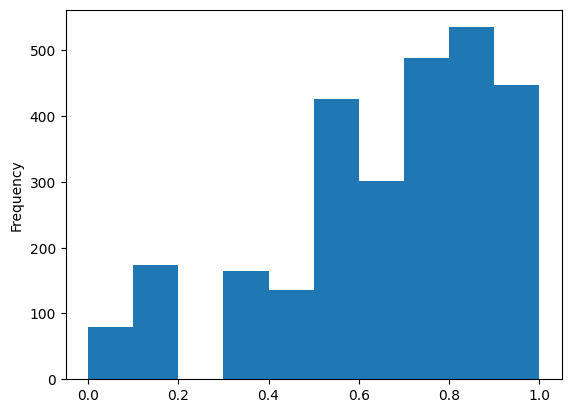

In [231]:
points.location_entropy.plot.hist()

In [80]:
points.groupby(['tile_ID']).TRIP_ID.nunique()

84.39999999999999

In [257]:
def get_inverse_loc_frequency(row, loc_frequencies, points):
    
    tl_ID = str(row.tile_ID)
    cl_ID = row.clustering_HL
    
    cl_loc_freqs = loc_frequencies.query('clustering_HL == @cl_ID')
        
    tf = row.freq/cl_loc_freqs.freq.sum()
    
    idf = math.log(points.clustering_HL.nunique()/(points.query('tile_ID == @tl_ID').clustering_HL.nunique() + 1))
    
    tf_idf = tf * idf
    
    return tf_idf
    
    
    
        

In [256]:
loc_frequencies

,clustering_HL,tile_ID,freq,tf_idf
0,1,2873,2,0.620104
1,1,2962,1,0.310052
2,1,3048,2,0.620104
3,1,3134,8,1.741059
4,1,3135,2,0.620104
...,...,...,...,...
1033,312,5550,3,0.960376
1034,313,5297,1,1.306949
1035,313,5550,1,0.960376
1036,314,5644,1,1.097022


<Axes: ylabel='Frequency'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

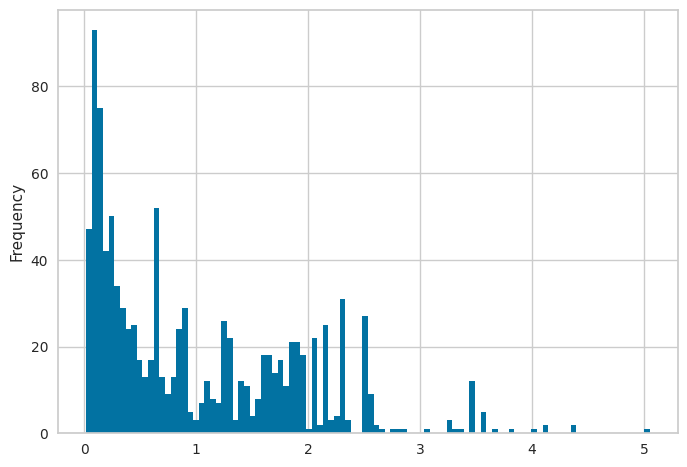

In [328]:
loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL').rename(columns={'TRIP_ID': 'freq'})
loc_frequencies['tf_idf'] = loc_frequencies.apply(lambda x: get_inverse_loc_frequency(x, loc_frequencies, points), axis=1)
loc_frequencies.tf_idf.plot.hist(bins=100)

In [265]:
points

,PERSON_ID,TRIP_ID,datetime,clustering_HL,lat,lng,geometry,tile_ID,location_entropy
0,17246,0,2022-10-21T14:59:24,21,52.530942,13.317532,POINT (13.31753 52.53094),4868,0.670968
1,17246,1,2022-10-21T16:07:38,21,52.538612,13.375194,POINT (13.37519 52.53861),5213,0.768943
2,17246,2,2022-10-21T19:16:16,21,52.538529,13.375381,POINT (13.37538 52.53853),5213,0.768943
3,17246,3,2022-10-21T20:41:59,73,52.531368,13.319161,POINT (13.31916 52.53137),4868,0.670968
4,16947,4,2022-10-23T09:32:44,45,52.528147,13.379241,POINT (13.37924 52.52815),5212,0.774609
...,...,...,...,...,...,...,...,...,...
1370,16356,1403,2022-11-17T18:13:33,6,52.534717,13.198952,POINT (13.19895 52.53472),4094,0.596234
1371,16356,1404,2022-11-17T18:35:06,6,52.531724,13.197715,POINT (13.19771 52.53172),4094,0.596234
1372,16370,1405,2022-11-17T19:17:50,58,52.508464,13.390704,POINT (13.39070 52.50846),5295,0.616716
1373,16370,1406,2022-11-17T21:02:04,58,52.508462,13.391137,POINT (13.39114 52.50846),5295,0.616716


In [263]:
def get_location_similarity(cl_i, cl_j, loc_frequencies, points):
    overlap_tile_ids = set(loc_frequencies.query("clustering_HL == @cl_i").tile_ID).intersection(set(loc_frequencies.query("clustering_HL == @cl_j").tile_ID))
    nr_overlapping_tiles = len(overlap_tile_ids)
    loc_sim = 0
    
    if nr_overlapping_tiles == 0:
        return loc_sim
    for t in overlap_tile_ids:
        cl_i_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_i) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        cl_j_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_j) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        
        loc_sim += points.query("tile_ID == @t").location_entropy.iloc[0] * min(cl_i_freq, cl_j_freq)
    return loc_sim/nr_overlapping_tiles

In [266]:
M = np.zeros((loc_frequencies.clustering_HL.nunique(), loc_frequencies.clustering_HL.nunique()))

for i, cl_i in tqdm(enumerate(loc_frequencies.clustering_HL.unique()), total=loc_frequencies.clustering_HL.nunique()):
    
    for j, cl_j in enumerate(loc_frequencies.clustering_HL.unique()):
        if i == j:
            continue
            
        M[i, j] = get_location_similarity(cl_i, cl_j, loc_frequencies, points)

# Symmetrize
# M = M + M.T

# M = np.max(M) - M

# Set diagonal to 0
np.fill_diagonal(M, 0)


100%|█████████████████████████████████████████████████████████████████████████████████| 314/314 [02:40<00:00,  1.96it/s]


In [268]:
np.nonzero(M[0])

(array([ 41, 112, 171]),)

In [270]:
np.argmax(M[0])

112

In [ ]:
M[174]

In [297]:
np.nonzero(sum(M == 2.795666886601611))

(array([172, 173, 174]),)

In [315]:
def get_5_max(M):
    max_5 = [0,0,0,0,0]
    max_5_indices = [(0,0), (0,0), (0,0), (0,0), (0,0)]
    
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if not all(x > M[i,j] for x in max_5):
                index_smallest_val = max_5.index(sorted(max_5, reverse=False)[0])
                max_5[index_smallest_val] = M[i,j]
                max_5_indices[index_smallest_val] = (i, j)
                
    return max_5_indices

get_5_max(M)

[(174, 173), (172, 174), (173, 172), (173, 174), (174, 172)]

In [319]:
for tup in get_5_max(M):
    print(tup)
    cl_1 = loc_frequencies.clustering_HL.unique()[tup[0]]
    cl_2 = loc_frequencies.clustering_HL.unique()[tup[1]]
    gdf['clustering_HL'] = gdf.clustering_HL.apply(lambda x: cl_1 if x == cl_2 else x)

(174, 173)
(172, 174)
(173, 172)
(173, 174)
(174, 172)


In [320]:
attack.evaluate(gdf.clustering_HL.tolist(), gdf)

Homogeneity: 0.894
Completeness: 0.724
V-measure: 0.800
Rand index: 0.982
ARI: 0.493
MI: 3.517
NMI: 0.800
AMI: 0.661
Cluster accuracy: 0.553


In [ ]:
for i in range(10):
    # Get new points gdf matched with tessellation that contains updated clustering column
    points = get_points(gdf, tessellation)
    
    # Compute location entropy for latest clustering
    points['location_entropy'] = points.tile_ID.progress_apply(lambda x: get_location_entropy(x, points))
    points['location_entropy'] = points.location_entropy.apply(lambda x: 1 - (x - points.location_entropy.min())/(points.location_entropy.max() - points.location_entropy.min()))
    print(points.location_entropy.plot.hist(bins=20))
    
    # Update location frequencies and loc frequency-inverse cluster frequency
    loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL').rename(columns={'TRIP_ID': 'freq'})
    loc_frequencies['tf_idf'] = loc_frequencies.apply(lambda x: get_inverse_loc_frequency(x, loc_frequencies, points), axis=1)
    print(loc_frequencies.tf_idf.plot.hist(bins=50))
    
    # Recalculate similarities between latest clusters
    M = np.zeros((loc_frequencies.clustering_HL.nunique(), loc_frequencies.clustering_HL.nunique()))
    for i, cl_i in tqdm(enumerate(loc_frequencies.clustering_HL.unique()), total=loc_frequencies.clustering_HL.nunique()):
        for j, cl_j in enumerate(loc_frequencies.clustering_HL.unique()):
            if i == j:
                continue
            M[i, j] = get_location_similarity(cl_i, cl_j, loc_frequencies, points)
    np.fill_diagonal(M, 0)
    
    # Select 5 best links and assign new clustering IDs
    print('New links of clusters:')
    for tup in get_5_max(M):
        cl_1 = loc_frequencies.clustering_HL.unique()[tup[0]]
        cl_2 = loc_frequencies.clustering_HL.unique()[tup[1]]
        print(cl_1, cl_2)
        gdf['clustering_HL'] = gdf.clustering_HL.apply(lambda x: cl_1 if x == cl_2 else x)
    
    # Evaluate result of iteration
    attack.evaluate(gdf.clustering_HL.tolist(), gdf)

100%|█████████████████████████████████████████████████████████████████████████████████| 312/312 [02:35<00:00,  2.01it/s]


(160, 159)
(156, 158)
(156, 159)
(156, 160)
(157, 156)
Homogeneity: 0.894
Completeness: 0.725
V-measure: 0.801
Rand index: 0.982
ARI: 0.493
MI: 3.517
NMI: 0.801
AMI: 0.662
Cluster accuracy: 0.553


100%|█████████████████████████████████████████████████████████████████████████████████| 308/308 [02:34<00:00,  2.00it/s]


(138, 137)
(131, 133)
(131, 136)
(131, 134)
(131, 132)
Homogeneity: 0.894
Completeness: 0.726
V-measure: 0.801
Rand index: 0.982
ARI: 0.494
MI: 3.517
NMI: 0.801
AMI: 0.664
Cluster accuracy: 0.553


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [02:28<00:00,  2.04it/s]


(133, 132)
(131, 133)
(133, 131)
(132, 131)
(131, 132)
Homogeneity: 0.894
Completeness: 0.727
V-measure: 0.802
Rand index: 0.982
ARI: 0.494
MI: 3.517
NMI: 0.802
AMI: 0.665
Cluster accuracy: 0.555


100%|█████████████████████████████████████████████████████████████████████████████████| 301/301 [02:28<00:00,  2.03it/s]


(146, 145)
(143, 144)
(144, 143)
(143, 145)
(144, 145)
Homogeneity: 0.894
Completeness: 0.727
V-measure: 0.802
Rand index: 0.982
ARI: 0.494
MI: 3.517
NMI: 0.802
AMI: 0.666
Cluster accuracy: 0.555


100%|█████████████████████████████████████████████████████████████████████████████████| 299/299 [02:25<00:00,  2.05it/s]


(161, 132)
(143, 144)
(128, 15)
(144, 143)
(132, 161)
Homogeneity: 0.894
Completeness: 0.728
V-measure: 0.802
Rand index: 0.982
ARI: 0.495
MI: 3.517
NMI: 0.802
AMI: 0.667
Cluster accuracy: 0.556


100%|█████████████████████████████████████████████████████████████████████████████████| 296/296 [02:23<00:00,  2.06it/s]


(17, 211)
(107, 133)
(133, 107)
(211, 17)
(73, 76)
Homogeneity: 0.893
Completeness: 0.728
V-measure: 0.802
Rand index: 0.982
ARI: 0.494
MI: 3.514
NMI: 0.802
AMI: 0.667
Cluster accuracy: 0.556


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [02:21<00:00,  2.07it/s]


(141, 198)
(112, 111)
(198, 141)
(101, 20)
(111, 112)
Homogeneity: 0.893
Completeness: 0.728
V-measure: 0.802
Rand index: 0.982
ARI: 0.494
MI: 3.511
NMI: 0.802
AMI: 0.667
Cluster accuracy: 0.556


100%|█████████████████████████████████████████████████████████████████████████████████| 290/290 [02:19<00:00,  2.08it/s]


(153, 280)
(127, 1)
(1, 127)
(280, 153)
(63, 234)
Homogeneity: 0.893
Completeness: 0.728
V-measure: 0.802
Rand index: 0.982
ARI: 0.495
MI: 3.510
NMI: 0.802
AMI: 0.668
Cluster accuracy: 0.556


100%|█████████████████████████████████████████████████████████████████████████████████| 287/287 [02:18<00:00,  2.07it/s]


(42, 233)
(151, 63)
(63, 151)
(233, 42)
(155, 80)
Homogeneity: 0.892
Completeness: 0.729
V-measure: 0.802
Rand index: 0.982
ARI: 0.496
MI: 3.508
NMI: 0.802
AMI: 0.669
Cluster accuracy: 0.557


100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [01:47<00:00, 25.62it/s]


In [251]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, OPTICS
import numpy as np

dbscan = DBSCAN(eps=2, min_samples=1, metric='precomputed').fit(M)
print(np.unique(dbscan.labels_).shape)

optics = OPTICS(min_samples=2, metric='precomputed').fit(M)
print(np.unique(optics.labels_).shape)

ac = AgglomerativeClustering(metric='precomputed', n_clusters=51, linkage='average').fit(M)
print(np.unique(ac.labels_).shape)


(162,)
(56,)
(51,)


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


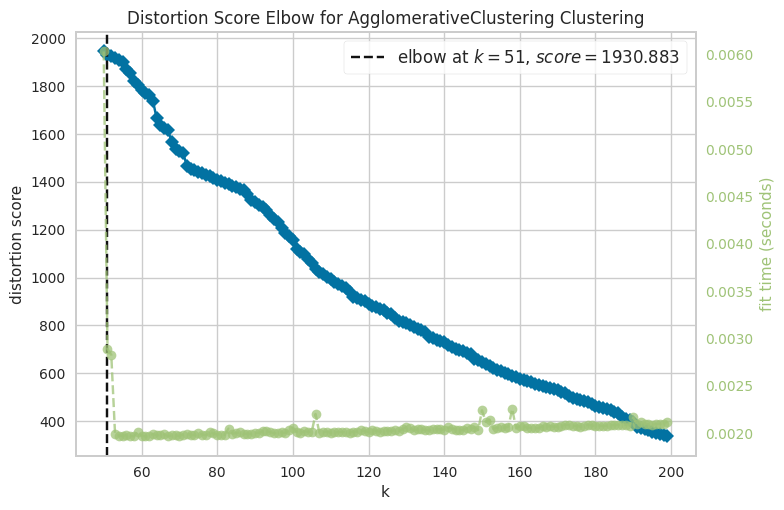

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(linkage='average',
                                                   metric='precomputed',
                                                   n_clusters=199),
                 k=(50, 200))

In [250]:
from yellowbrick.cluster import kelbow_visualizer

# Instantiate the clustering model and visualizer

kelbow_visualizer(AgglomerativeClustering(metric='precomputed', linkage='average'), M, k=(50,200))

In [252]:
trip_id_cluster_dict = gdf[['TRIP_ID', 'clustering_HL']].set_index('TRIP_ID').to_dict()['clustering_HL']

dbscan_clustering = dict(zip(loc_frequencies.clustering_HL.unique(), dbscan.labels_))
dbscan_clustering = [dbscan_clustering[trip_id_cluster_dict[key]] for key in trip_id_cluster_dict.keys()]

optics_clustering = dict(zip(loc_frequencies.clustering_HL.unique(), optics.labels_))
optics_clustering = [optics_clustering[trip_id_cluster_dict[key]] for key in trip_id_cluster_dict.keys()]

ac_clustering = dict(zip(loc_frequencies.clustering_HL.unique(), ac.labels_))
ac_clustering = [ac_clustering[trip_id_cluster_dict[key]] for key in trip_id_cluster_dict.keys()]



In [253]:
attack.evaluate(gdf.clustering_HL.tolist(), gdf)

attack.evaluate(dbscan_clustering, gdf)

attack.evaluate(optics_clustering, gdf)

attack.evaluate(ac_clustering, gdf)

Homogeneity: 0.894
Completeness: 0.724
V-measure: 0.800
Rand index: 0.982
ARI: 0.493
MI: 3.517
NMI: 0.800
AMI: 0.660
Cluster accuracy: 0.553
Homogeneity: 0.819
Completeness: 0.746
V-measure: 0.781
Rand index: 0.980
ARI: 0.492
MI: 3.219
NMI: 0.781
AMI: 0.674
Cluster accuracy: 0.589
Homogeneity: 0.427
Completeness: 0.706
V-measure: 0.532
Rand index: 0.699
ARI: 0.048
MI: 1.680
NMI: 0.532
AMI: 0.403
Cluster accuracy: 0.357
Homogeneity: 0.650
Completeness: 0.765
V-measure: 0.703
Rand index: 0.955
ARI: 0.343
MI: 2.556
NMI: 0.703
AMI: 0.628
Cluster accuracy: 0.498


In [159]:
gdf.PERSON_ID.nunique()

72